In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.colors as plc 
import xclim.indices as xc
from xclim.indices import warm_and_dry_days
from xclim.indices import warm_and_wet_days
from xclim.core.calendar import percentile_doy
#import pymannkendall as mk
import geopandas as gpd

from xclim.core.units import (
    convert_units_to,
    declare_units,
    ensure_delta,
    pint2cfunits,
    rate2amount,
    str2pint,
    to_agg_units,
)
from xclim.core.calendar import resample_doy
import colormap as zcol

## Colorbar

In [1]:
import sys
sys.path.insert(0,'/home/jovyan/pilot2/zapata/')
import mycolormap as zcol
ss = zcol.make_cmap('3w_bgYr', colpath ='/home/jovyan/pilot2/zapata/SciVis_colormaps/')

Using colormap /home/jovyan/pilot2/zapata/SciVis_colormaps//3w_bgYr.xml


## Path

In [2]:
path= '/home/jovyan/pilot2/data/Vhr-rea_It'
path_era5land='/home/jovyan/pilot2/data/Era5_land'
path_nc= '/home/jovyan/pilot2/Output/netcdf'
path_csv= '/home/jovyan/pilot2/Output/csv'
path_shape= '/home/jovyan/pilot2/Output/shape'
path_mask= '/home/jovyan/pilot2/mask_Torino'
path_map= '/home/jovyan/pilot2/Output/map'

## Comments on the code

In [ ]:
"""
Climate hazard indicators calculation

The calculation process follows a standardized structure for all indicators,
divided into the following steps:

1) Data loading and extraction of required variables
2) Indicator calculation (using the Python library xclim, 
   where available)
3) Output generation in the following formats: CSV, Shapefile, and PNG

Note: For some indicators, intermediate variables may have been calculated
when not directly available in the source dataset.
"""

## Summer Days= Number of days with daily maximum temperature greater than 25°C. 

In [9]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"

In [14]:
##Evaluation
Su=xc.tx_days_above(tasmax_K, thresh='25 degC', freq='YS')
Su_mean=Su.mean(dim='time')
Su_mean=Su_mean.to_dataset(name='SU')
#Su=Su_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/su_era5_land-italy_year_comune_torino_1991-2020.nc')

In [17]:
#CSV
Su_mean=Su.mean(dim= ['latitude','longitude']) 
Su_std=Su.std(dim= ['latitude','longitude'])
df=Su_mean.to_dataframe().reset_index().rename(columns= {'temp_max':'Su[days]'})
df_std=Su_std.to_dataframe().reset_index().rename(columns= {'temp_max':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Su[days]'] = np.round(df['Su[days]'],0)
df.to_csv(path_csv+'/su_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [21]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Su_mean= Su.mean(dim='time')
clip_var = msk_me * Su_mean
ds=clip_var.to_dataset(name='Su[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Su[d]'] = np.round(df['Su[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/su_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_1047/1058039616.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_1047/1058039616.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


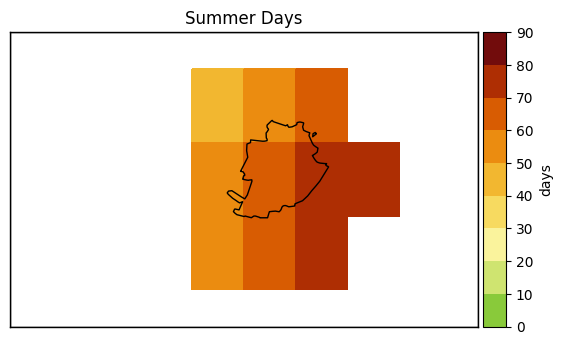

In [24]:
# Map
ds = xr.open_dataset(path_nc+'/su_era5_land-italy_year_comune_torino_1991-2020.nc')
Su = np.round((ds['SU']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(Su),0) 
vmin = 0
ticks = np.round(np.arange(vmin, vmax+5,10),0)
ticks_label = np.round(np.arange(vmin, vmax+5,10),0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Su

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Summer Days')
plt.savefig(path_map+'/su_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Tropical Nights= Number of days with daily minimum temperature greater than 20°C

In [26]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmin_era5land_1991_2020.nc', engine='netcdf4')
tasmin=data_temp['temp_min']
tasmin_K=tasmax+273.15
tasmin_K.attrs["units"] = "K"

In [33]:
##Evaluation
Tr= xc.tn_days_above(tasmin_K, thresh='20.0 degC', freq='YS')
Tr_mean=Tr.mean(dim='time')
Tr_mean=Tr_mean.to_dataset(name='TR')
Tr=Tr_mean.to_netcdf(path_nc+'/tr_era5_land-italy_year_comune_torino_1991-2020.nc')

In [29]:
#CSV
Tr_mean=Tr.mean(dim= ['latitude','longitude']) 
Tr_std=Tr.std(dim= ['latitude','longitude'])
df=Tr_mean.to_dataframe().reset_index().rename(columns= {'temp_min':'Tr[days]'})
df_std=Tr_std.to_dataframe().reset_index().rename(columns= {'temp_min':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tr[days]'] = np.round(df['Tr[days]'],0)
df.to_csv(path_csv+'/tr_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [30]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Tr_mean= Tr.mean(dim='time')
clip_var = msk_me * Tr_mean
ds=clip_var.to_dataset(name='Tr[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Tr[d]'] = np.round(df['Tr[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/tr_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_1047/199456860.py:40: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)


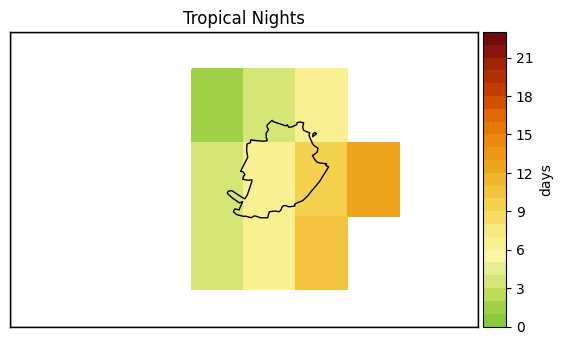

In [57]:
# Map
ds = xr.open_dataset(path_nc+'/tr_era5_land-italy_year_comune_torino_1991-2020.nc')
Tr = np.round((ds['TR']), 0)
lon = ds.longitude.values
lat = ds.latitude.values

# Crea la griglia 2D dalle coordinate
lon2d, lat2d = np.meshgrid(lon, lat)

# Definisci i parametri per la colorbar
vmax = round(np.nanmax(Tr), 0) 
vmin = 0
ticks = np.round(np.arange(vmin, vmax+1, 3), 0)

# Crea la colormap con il numero corretto di colori
n_colors = int(vmax - vmin)   # Un colore per ogni valore intero
colors = ss(np.linspace(0.6, 0.97, n_colors))
cmap = plc.ListedColormap(colors)

# Apri il dataset della maschera
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Tr

# Crea la mappa
mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

# Plotta i dati
c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap, vmin=vmin, vmax=vmax)

# Crea la colorbar
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)
cbar.set_label('days')

plt.title('Tropical Nights')
plt.savefig(path_map+'/tr_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Hot waves= Number of days with daily maximum temperature greater than 35°C.

In [7]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"

In [10]:
##Evaluation
Hw=xc.tx_days_above(tasmax_K, thresh='35 degC', freq='YS')
Hw_mean=Hw.mean(dim='time')
Hw_mean=Hw_mean.to_dataset(name='HW')
#Hw=Hw_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/hw_era5_land-italy_year_comune_torino_1991-2020.nc')

In [11]:
#CSV
Hw_mean=Hw.mean(dim= ['latitude','longitude']) 
Hw_std=Hw.std(dim= ['latitude','longitude'])
df=Hw_mean.to_dataframe().reset_index().rename(columns= {'temp_max':'Hw[days]'})
df_std=Hw_std.to_dataframe().reset_index().rename(columns= {'temp_max':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Hw[days]'] = np.round(df['Hw[days]'],0)
df.to_csv(path_csv+'/hw_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [12]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Hw_mean= Hw.mean(dim='time')
clip_var = msk_me * Hw_mean
ds=clip_var.to_dataset(name='Hw[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Hw[d]'] = np.round(df['Hw[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/hw_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_131/3460477208.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_131/3460477208.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


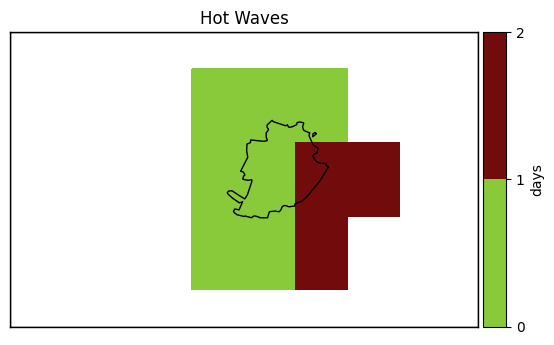

In [17]:
# Map
ds = xr.open_dataset(path_nc+'/hw_era5_land-italy_year_comune_torino_1991-2020.nc')
Hw = np.round((ds['HW']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(Hw),0) 
vmin = 0
# Cambia il passo da 10 a 5 o un valore più piccolo
ticks = np.round(np.arange(vmin, vmax+1, 1), 0)  # invece di 10
ticks_label = np.round(np.arange(vmin, vmax+1, 1), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Hw

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Hot Waves')
plt.savefig(path_map+'/hw_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Warm Days= Number of days with daily maximum temperature greater than the 90th percentile of daily maximum temperature

In [4]:
#Loading data: Max. Temperature and Percentile
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"
tasmax_per=percentile_doy(tasmax_K, window=5, per=90).sel(percentiles=90)

In [5]:
##Evaluation
Warm_days=xc.tx90p(tasmax_K,tasmax_per, freq='YS', bootstrap=False)
Warm_days_mean=Warm_days.mean(dim='time')
Warm_days_mean=Warm_days_mean.to_dataset(name='Wd')
#Warm_days=Warm_days_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/warm_days_era5_land-italy_year_comune_torino_1991-2020.nc')

In [28]:
#CSV
ds=Warm_days.to_dataset(name='Tx90p[days]')
Tx90p_mean=ds.mean(dim= ['latitude','longitude']) 
Tx90p_std=ds.std(dim= ['latitude','longitude'])
df=Tx90p_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Tx90p_std.to_dataframe().reset_index().rename(columns= {'Tx90p[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tx90p[days]'] = np.round(df['Tx90p[days]'],0)
df.to_csv(path_csv+'/warm_days_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Warm_days_mean=Warm_days.mean(dim='time')
clip_var = msk_me * Warm_days_mean
ds=clip_var.to_dataset(name='Tx90p[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Tx90p[d]'] = np.round(df['Tx90p[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/warm_days_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_1021/2114594262.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_1021/2114594262.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


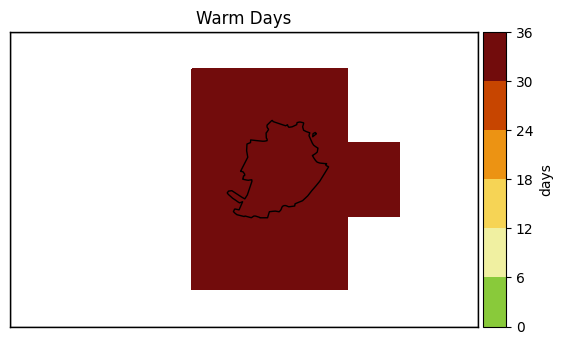

In [6]:
# Map
ds = xr.open_dataset(path_nc+'/warm_days_era5_land-italy_year_comune_torino_1991-2020.nc')
tx90p = np.round((ds['Wd']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(tx90p),0) 
vmin = 0
# Cambia il passo da 10 a 5 o un valore più piccolo
ticks = np.round(np.arange(vmin, vmax+1, 6), 0)  # invece di 10
ticks_label = np.round(np.arange(vmin, vmax+1, 6), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * tx90p

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Warm Days')
plt.savefig(path_map+'/warm_days_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Humidex5= It is a measure of perceived heat that results from the combined effect of humidity and temperature. Category 5: number of days per year in which the humidex index is greater than 45°C. 

In [7]:
#Loading data: Mean Temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020.nc', engine='netcdf4')
tas=data_temp['temp_mean']
tas_k=tas+273.15
tas_k.attrs["units"] = "K"

In [8]:
#Loading data: Dew Point Temperature
data_temp= xr.open_dataset(path_era5land+'/tdmean_era5land_1991_2020.nc', engine='netcdf4')
td=data_temp['dewpoint_mean']
td_k=td+273.15
td_k.attrs["units"] = "K"

In [9]:
#Components for the evaluation of the index
e_d=6.112 * (2.71828 ** ((17.67 * td_k) / (td_k + 243.5)))  #formula Magnus-Tetens
e_s=6.112 * (2.71828 ** ((17.67 * tas_k) / (tas_k + 243.5))) #formula Magnus-Tetens
rh= 100 * (e_d / e_s)
rh.attrs["units"] = "%"
rh = rh.load()

In [10]:
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax = tasmax.load()

In [11]:
#Evaluation
exphum=6.11*10**(7.5*tasmax/(237.7+tasmax))*rh.values/100;
humidex=tasmax+0.5555*(exphum-10);
classe_media1=xr.where(humidex >=45,1,0)   #Category 5-number of days per year in which the humidex index is greater than 45°C.
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='Humidex5')
#Humidex5=classe_media3.to_netcdf('/home/jovyan/pilot2/Output/netcdf/humidex5_era5_land-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [22]:
#CSV
ds=classe_media2.to_dataset(name='Humidex5[days]')
Humidex5_mean=ds.mean(dim= ['latitude','longitude']) 
Humidex5_std=ds.std(dim= ['latitude','longitude'])
df=Humidex5_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Humidex5_std.to_dataframe().reset_index().rename(columns= {'Humidex5[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Humidex5[days]'] = np.round(df['Humidex5[days]'],0)
df.to_csv(path_csv+'/humidex5_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Humidex5_mean=classe_media2.mean(dim='time')
clip_var = msk_me * Humidex5_mean
ds=clip_var.to_dataset(name='Humidex5[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Humidex5[d]'] = np.round(df['Humidex5[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/humidex5_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_1021/1940041219.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_1021/1940041219.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


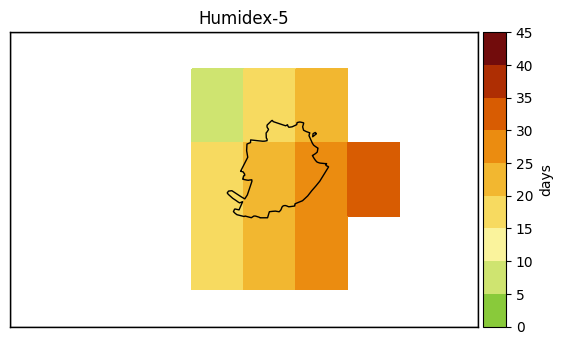

In [12]:
# Map
ds = xr.open_dataset(path_nc+'/humidex5_era5_land-italy_year_comune_torino_1991-2020.nc')
humidex5 = np.round((ds['Humidex5']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(humidex5),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1, 5), 0)  
ticks_label = np.round(np.arange(vmin, vmax+1, 5), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * humidex5

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Humidex-5')
plt.savefig(path_map+'/humidex5_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## WSDI= Total number of days per period in which the daily maximum temperature is greater than the 90th percentile of the daily maximum temperature in intervals of at least 6 consecutive days.

In [32]:
#Loading data: Max. Temperature and Percentile
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"
tasmax_per=percentile_doy(tasmax_K, window=5, per=90).sel(percentiles=90)

In [33]:
#Evaluation
WSDI=xc.warm_spell_duration_index(tasmax_K, tasmax_per, window=6, freq='YS')
WSDI_mean=WSDI.mean(dim='time')
WSDI_mean=WSDI_mean.to_dataset(name='WSDI')
Wsdi=WSDI_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/wsdi_era5_land-italy_year_comune_torino_1991-2020.nc')

In [34]:
#CSV
ds=WSDI.to_dataset(name='Wsdi[days]')
Wsdi_mean=ds.mean(dim= ['latitude','longitude']) 
Wsdi_std=ds.std(dim= ['latitude','longitude'])
df=Wsdi_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Wsdi_std.to_dataframe().reset_index().rename(columns= {'Wsdi[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Wsdi[days]'] = np.round(df['Wsdi[days]'],0)
df.to_csv(path_csv+'/wsdi_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Wsdi_mean=WSDI.mean(dim='time')
clip_var = msk_me * Wsdi_mean
ds=clip_var.to_dataset(name='Wsdi[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Wsdi[d]'] = np.round(df['Wsdi[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/wsdi_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_192/2968126741.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_192/2968126741.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


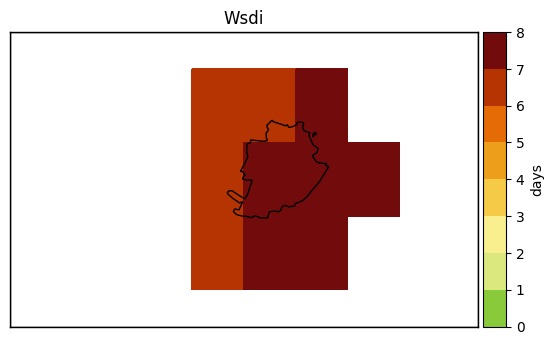

In [41]:
# Map
ds = xr.open_dataset(path_nc+'/wsdi_era5_land-italy_year_comune_torino_1991-2020.nc')
WSDI = np.round((ds['WSDI']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(WSDI),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1, 1), 0)  
ticks_label = np.round(np.arange(vmin, vmax+1, 1), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * WSDI

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Wsdi')
plt.savefig(path_map+'/wsdi_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## WS3DI= Total number of days per period in which the daily maximum temperature is greater than the 90th percentile of the daily maximum temperature in intervals of at least 3 consecutive days.

In [48]:
#Loading data: Max. Temperature and Percentile
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"
tasmax_per=percentile_doy(tasmax_K, window=30, per=90).sel(percentiles=90)

In [49]:
#Evaluation
WS3DI=xc.warm_spell_duration_index(tasmax_K, tasmax_per, window=3, freq='YS')
WS3DI_mean=WS3DI.mean(dim='time')
WS3DI_mean=WS3DI_mean.to_dataset(name='WS3DI')
Ws3di=WS3DI_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/ws3di_era5_land-italy_year_comune_torino_1991-2020.nc')

In [45]:
#CSV
ds=WS3DI.to_dataset(name='Ws3di[days]')
Ws3di_mean=ds.mean(dim= ['latitude','longitude']) 
Ws3di_std=ds.std(dim= ['latitude','longitude'])
df=Ws3di_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Ws3di_std.to_dataframe().reset_index().rename(columns= {'Ws3di[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Ws3di[days]'] = np.round(df['Ws3di[days]'],0)
df.to_csv(path_csv+'/ws3di_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Ws3di_mean=WS3DI.mean(dim='time')
clip_var = msk_me * Ws3di_mean
ds=clip_var.to_dataset(name='Ws3di[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Ws3di[d]'] = np.round(df['Ws3di[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/ws3di_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_192/1788014238.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_192/1788014238.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


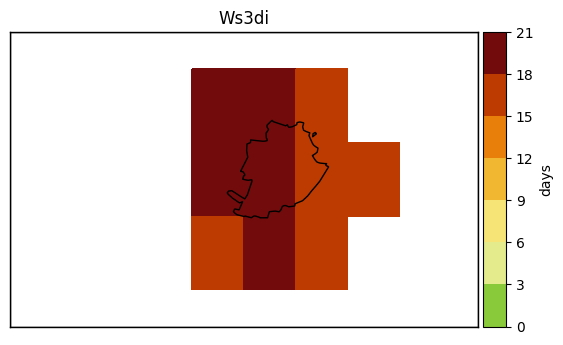

In [53]:
# Map
ds = xr.open_dataset(path_nc+'/ws3di_era5_land-italy_year_comune_torino_1991-2020.nc')
WS3DI = np.round((ds['WS3DI']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(WS3DI),0) 
vmin = 0
# Cambia il passo da 10 a 5 o un valore più piccolo
ticks = np.round(np.arange(vmin, vmax+1, 3), 0)  # invece di 10
ticks_label = np.round(np.arange(vmin, vmax+1, 3), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * WS3DI

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Ws3di')
plt.savefig(path_map+'/ws3di_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Apparent Temperature= It represents the temperature perceived by human beings, resulting from the combined effect of air temperature, relative humidity.

In [13]:
#Loading data: Mean Temperature and Dew Point Temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020.nc', engine='netcdf4')
tas=data_temp['temp_mean']
tas["units"] = "°C"

data_temp_td= xr.open_dataset(path_era5land+'/tdmean_era5land_1991_2020.nc', engine='netcdf4')
td=data_temp_td['dewpoint_mean']
td["units"] = "°C"

In [14]:
#Evaluation
TApp= -2.653 + 0.994 * tas + 0.0153 * (td)**2;  #Tapp = −2.653 + 0.994 × Ta + 0 0153 × Td2

In [15]:
#Evaluation
condition= (TApp>=32) & (TApp<40)  #Threshold indicating conditions of extreme caution
classe=xr.where(condition,1,0)
classe_new=classe.resample(time='1YE').sum(dim='time')
classe_media=classe_new.mean(dim='time')
classe_media1=classe_media.to_dataset(name='TApp')
#TApp=classe_media1.to_netcdf('/home/jovyan/pilot2/Output/netcdf/tapp_era5_land-italy_year_comune_torino_1991-2020.nc')

In [8]:
#CSV
ds=classe_new.to_dataset(name='TApp[days]')
TApp_mean=ds.mean(dim= ['latitude','longitude']) 
TApp_std=ds.std(dim= ['latitude','longitude'])
df=TApp_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=TApp_std.to_dataframe().reset_index().rename(columns= {'TApp[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['TApp[days]'] = np.round(df['TApp[days]'],0)
df.to_csv(path_csv+'/tapp_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

TApp_mean=classe_new.mean(dim='time')
clip_var = msk_me * TApp_mean
ds=clip_var.to_dataset(name='TApp[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['TApp[d]'] = np.round(df['TApp[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/tapp_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_1021/2885442232.py:41: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_1021/2885442232.py:42: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


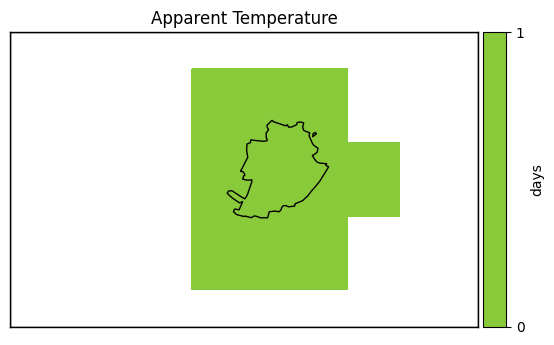

<Figure size 640x480 with 0 Axes>

In [16]:
# Maps
TApp = classe_media
lon = classe_media.longitude.values
lat = classe_media.latitude.values


if lon.ndim == 1 and lat.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat

vmax = round(np.nanmax(TApp), 0)
vmin = 0
ticks = np.round(np.arange(vmin, vmax+1, 1), 1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1), 1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * TApp

mp = Basemap(projection='merc', 
             llcrnrlon=np.nanmin(lon), 
             llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), 
             urcrnrlat=np.nanmax(lat), 
             resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:, :]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Apparent Temperature')
plt.show()
plt.savefig(path_map+'/tapp_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Discomfort Index= It is a physiological thermal stress indicator for people based on dry-bulb and wet-bulb temperature.

In [5]:
#Loading data: Mean Temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020.nc', engine='netcdf4')
tas=data_temp['temp_mean']

In [6]:
#Loading data: Dew Point Temperature
data_temp= xr.open_dataset(path_era5land+'/tdmean_era5land_1991_2020.nc', engine='netcdf4')
td=data_temp['dewpoint_mean']

In [7]:
#Components for the evaluation of the index
e_d=6.112 * (2.71828 ** ((17.67 * td) / (td + 243.5)))  #formula di Magnus-Tetens
e_s=6.112 * (2.71828 ** ((17.67 * tas) / (tas+ 243.5))) #formula di Magnus-Tetens
rh= 100 * (e_d / e_s)
rh.attrs["units"] = "%"
rh = rh.load()

In [12]:
#Loading data: Max. Temperature 
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']

In [13]:
#Evaluation
THI=tasmax-(0.55 - 0.0055*rh) *(tasmax-14.5)    #THI = Ta - (0.55 - 0.0055 * UR) (Ta - 14.5). Since it is not always possible to know the wet bulb temperature, the formula of the Thermohygrometric Index (THI) can be used
condition= (THI>=29) & (THI<32) #Threshold indicating dangerous conditions
classe=xr.where(condition,1,0)
classe_media=classe.resample(time='1YE').sum(dim='time')
classe_media1=classe_media.mean(dim='time')
classe_media2=classe_media1.to_dataset(name='Di')
#Di=classe_media2.to_netcdf('/home/jovyan/pilot2/Output/netcdf/di_era5_land-italy_year_comune_torino_1991-2020.nc')

In [28]:
#CSV
ds=classe_media.to_dataset(name='Di[days]')
Di_mean=ds.mean(dim= ['latitude','longitude']) 
Di_std=ds.std(dim= ['latitude','longitude'])
df=Di_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Di_std.to_dataframe().reset_index().rename(columns= {'Di[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Di[days]'] = np.round(df['Di[days]'],0)
#df.to_csv(path_csv+'/di_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Di_mean=classe_media.mean(dim='time')
clip_var = msk_me * Di_mean
ds=clip_var.to_dataset(name='Di[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Di[d]'] = np.round(df['Di[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/di_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_175/1046776276.py:40: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_175/1046776276.py:41: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


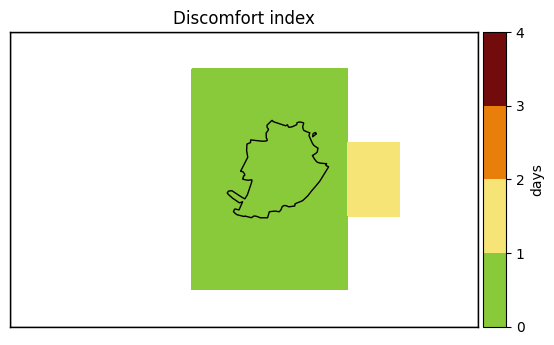

<Figure size 640x480 with 0 Axes>

In [14]:
# Maps
Di = classe_media2.Di
lon = classe_media2.longitude.values
lat = classe_media2.latitude.values


if lon.ndim == 1 and lat.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat

vmax = round(np.nanmax(Di), 0)
vmin = 0
ticks = np.round(np.arange(vmin, vmax+1, 1), 1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1), 1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Di

mp = Basemap(projection='merc', 
             llcrnrlon=np.nanmin(lon), 
             llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), 
             urcrnrlat=np.nanmax(lat), 
             resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:, :]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Discomfort index')
plt.show()
plt.savefig(path_map+'/Di_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Warm Wet Days= Number of days with daily mean temperature greater than 75th percentile* of daily mean temperature and with daily precipitation greater than 75th percentile** of daily precipitation

In [12]:
#Loading data: Mean Temperature and 75th percentile of temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020.nc', engine='netcdf4')
tas=data_temp['temp_mean']
tas_k=tas+273.15
tas_k.attrs["units"] = "K"
tas_per=percentile_doy(task_k, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [9]:
#Loading data: precipitation and 75th percentile of precipitation
data_prec = xr.open_dataset(path_era5land+'/precip_era5land_1991_2020.nc', engine='netcdf4')
pr=data_prec['precip_sum']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=75).sel(percentiles=75)
pr_per.attrs["units"] = "mm/day"

In [13]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas_k)
thresh = resample_doy(tas_per, tas_k)
tg75 = task_k >= thresh
tg75=tg75.values

In [14]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh = resample_doy(pr_per, pr)
pr75 = pr >= thresh

In [15]:
#Evaluation
WW= (tg75==True) & (pr75==True)
classe_media1= xr.where(WW,1,0)
classe_media2=classe_media1.resample(time='1YE').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WW')
warm_and_wet=classe_media3.to_netcdf('/home/jovyan/pilot2/Output/netcdf/ww_era5_land-italy_year_comune_torino_1991-2020.nc')

In [16]:
#CSV
ds=classe_media2.to_dataset(name='WW[days]')
WW_mean=ds.mean(dim= ['latitude','longitude']) 
WW_std=ds.std(dim= ['latitude','longitude'])
df=WW_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=WW_std.to_dataframe().reset_index().rename(columns= {'WW[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WW[days]'] = np.round(df['WW[days]'],0)
df.to_csv(path_csv+'/ww_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

WW_mean=classe_media2.mean(dim='time')
clip_var = msk_me * WW_mean
ds=clip_var.to_dataset(name='WW[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['WW[d]'] = np.round(df['WW[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/ww_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_123/1231470336.py:41: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_123/1231470336.py:42: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


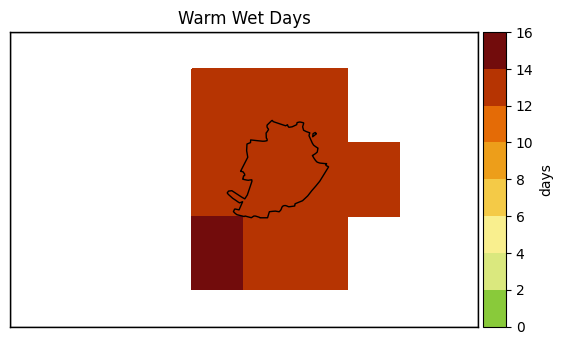

<Figure size 640x480 with 0 Axes>

In [25]:
# Maps
Ww = classe_media3.WW
lon = classe_media3.longitude.values
lat = classe_media3.latitude.values


if lon.ndim == 1 and lat.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat

vmax = round(np.nanmax(Ww), 0)
vmin = 0
ticks = np.round(np.arange(vmin, vmax+1, 2), 1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 2), 1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Ww

mp = Basemap(projection='merc', 
             llcrnrlon=np.nanmin(lon), 
             llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), 
             urcrnrlat=np.nanmax(lat), 
             resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:, :]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Warm Wet Days')
plt.show()
plt.savefig(path_map+'/ww_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Warm Dry Days= Number of days with daily mean temperature greater than 75th percentile** of daily mean temperature and with daily precipitation less than 25th percentile** of daily precipitation

In [29]:
#Loading data: Mean Temperature and 75th percentile of temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020.nc', engine='netcdf4')
tas=data_temp['temp_mean']
tas_k=tas+273.15
tas_k.attrs["units"] = "K"
tas_per=percentile_doy(task_k, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [30]:
#Loading data: precipitation and 75th percentile of precipitation
data_prec = xr.open_dataset(path_era5land+'/precip_era5land_1991_2020.nc', engine='netcdf4')
pr=data_prec['precip_sum']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=25).sel(percentiles=25)
pr_per.attrs["units"] = "mm/day"

In [32]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas_k)
thresh = resample_doy(tas_per, tas_k)
tg75 = task_k >= thresh
tg75=tg75.values

In [33]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh1 = resample_doy(pr_per, pr)
pr25 = pr <= thresh1

In [34]:
#Evaluation
WD= (tg75==True) & (pr25==True)
classe_media1= xr.where(WD,1,0)
classe_media2=classe_media1.resample(time='1YE').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WD')
warm_and_dry=classe_media3.to_netcdf('/home/jovyan/pilot2/Output/netcdf/wd_era5_land-italy_year_comune_torino_1991-2020.nc')

In [35]:
#CSV
ds=classe_media2.to_dataset(name='WD[days]')
WD_mean=ds.mean(dim= ['latitude','longitude']) 
WD_std=ds.std(dim= ['latitude','longitude'])
df=WD_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=WD_std.to_dataframe().reset_index().rename(columns= {'WD[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WD[days]'] = np.round(df['WD[days]'],0)
df.to_csv(path_csv+'/wd_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

WD_mean=classe_media2.mean(dim='time')
clip_var = msk_me * WD_mean
ds=clip_var.to_dataset(name='WD[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['WD[d]'] = np.round(df['WD[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/wd_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_123/1184256648.py:56: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)


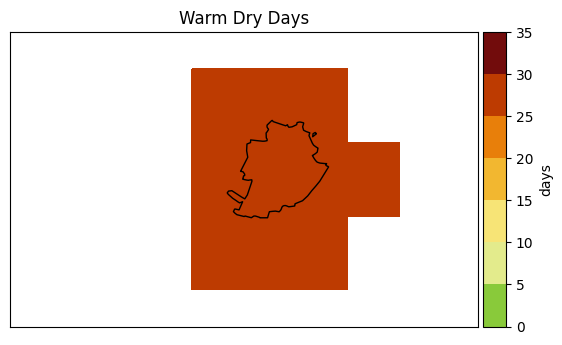

<Figure size 640x480 with 0 Axes>

In [51]:
# Maps
Wd = classe_media3.WD
lon = classe_media3.longitude.values
lat = classe_media3.latitude.values


if lon.ndim == 1 and lat.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat


vmin = 0
vmax = np.nanmax(Wd)


ticks = np.arange(vmin, np.ceil(vmax/5)*5 + 1, 5)


bounds = ticks.copy()
if vmax > bounds[-1]:
    bounds = np.append(bounds, vmax)


bounds = np.unique(bounds)


colors = ss(np.linspace(0.6, 0.97, len(bounds)-1))
cmap = plc.ListedColormap(colors)

from matplotlib.colors import BoundaryNorm
norm = BoundaryNorm(bounds, cmap.N, clip=True)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Wd


mp = Basemap(
    projection='merc',
    llcrnrlon=np.nanmin(lon),
    llcrnrlat=np.nanmin(lat),
    urcrnrlon=np.nanmax(lon),
    urcrnrlat=np.nanmax(lat),
    resolution='i'
)

x, y = mp(lon2d, lat2d)
mp.drawcoastlines(linewidth=1)
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)


c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:, :]), cmap=cmap, norm=norm)


cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)
cbar.set_label('days')

plt.title('Warm Dry Days')
plt.show()
plt.savefig(path_map+'/wd_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Maximum Apparent Temperature 

In [30]:
#Loading data: Mean Temperature and Dew Point Temperature
data_temp= xr.open_dataset(path_era5land+'/tmean_era5land_1991_2020_1h.nc', engine='netcdf4')
tas=data_temp['temp_hourly_mean']
tas["units"] = "°C"

data_temp_td= xr.open_dataset(path_era5land+'/tdmean_era5land_1991_2020_1h.nc', engine='netcdf4')
td=data_temp_td['dewpoint_hourly_mean']
td["units"] = "°C"

In [31]:
#Evaluation
TAppmax= -2.653 + 0.994 * tas + 0.0153 * (td)**2  #Tapp = −2.653 + 0.994 × Ta + 0 0153 × Td2
TAppmax_daily=TAppmax.resample(time='1D').max(dim='time')

In [32]:
#Evaluation
condition= (TAppmax_daily>=32) & (TAppmax_daily<40)  #Threshold indicating conditions of extreme caution
classe=xr.where(condition,1,0)
classe_new=classe.resample(time='1Y').sum(dim='time')
classe_media=classe_new.mean(dim='time')
#TAppmax=classe_media.to_netcdf('/home/jovyan/pilot2/Output/netcdf/tappmax_era5_land-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [58]:
#CSV
ds=classe_new.to_dataset(name='TAppmax[days]')
TAppmax_mean=ds.mean(dim= ['latitude','longitude']) 
TAppmax_std=ds.std(dim= ['latitude','longitude'])
df=TAppmax_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=TAppmax_std.to_dataframe().reset_index().rename(columns= {'TAppmax[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['TAppmax[days]'] = np.round(df['TAppmax[days]'],0)
df.to_csv(path_csv+'/tappmax_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

TAppmax_mean=classe_new.mean(dim='time')
clip_var = msk_me * TAppmax_mean
ds=clip_var.to_dataset(name='TAppmax[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['TAppmax[d]'] = np.round(df['TAppmax[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/tappmax_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_1021/3449629534.py:55: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)


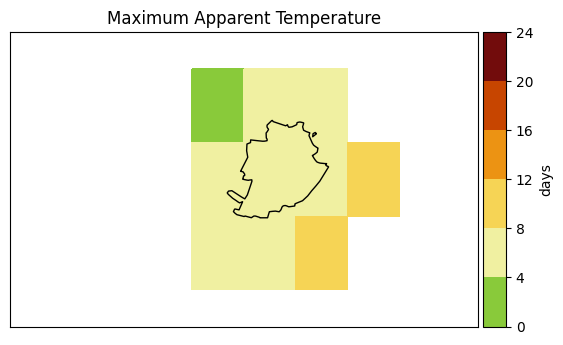

<Figure size 640x480 with 0 Axes>

In [33]:
# Maps
TAppmax= classe_media
lon = classe_media3.longitude.values
lat = classe_media3.latitude.values


if lon.ndim == 1 and lat.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat


vmin = 0
vmax = np.nanmax(TAppmax)


ticks = np.arange(vmin, np.ceil(vmax/4)*4 + 1, 4)

bounds = ticks.copy()
if vmax > bounds[-1]:
    bounds = np.append(bounds, vmax)


bounds = np.unique(bounds)


colors = ss(np.linspace(0.6, 0.97, len(bounds)-1))
cmap = plc.ListedColormap(colors)

from matplotlib.colors import BoundaryNorm
norm = BoundaryNorm(bounds, cmap.N, clip=True)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * TAppmax


mp = Basemap(
    projection='merc',
    llcrnrlon=np.nanmin(lon),
    llcrnrlat=np.nanmin(lat),
    urcrnrlon=np.nanmax(lon),
    urcrnrlat=np.nanmax(lat),
    resolution='i'
)

x, y = mp(lon2d, lat2d)
mp.drawcoastlines(linewidth=1)
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)


c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:, :]), cmap=cmap, norm=norm)


cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)
cbar.set_label('days')

plt.title('Maximum Apparent Temperature')
plt.show()
plt.savefig(path_map+'/maximum_apparent_temperature_era5_land_year_comune_torino_1991-2020.png', dpi=300)